In [ ]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import csv
import openpyxl
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import metrics
from sklearn import tree

plt.rcParams['figure.figsize'] = (10.0, 8.0)

#### This data has some weird encoding issues... need a helper function

In [ ]:
def xuni(s):
    if not s:
        return u''
    elif type(s) == unicode:
        return s.encode('utf-8')
    elif type(s) == str:
        return unicode(s, 'utf-8')
    else: return ''
    

### Convert xlsx to csv, dealing with encoding issues
Notes: 
* made a file with just three columns, date, reviews and 2_or_more_ill
* also dropped '3' and '9' labels because they can't help (and there's only like 5 total)


In [ ]:
wb = openpyxl.load_workbook('yelp_mult_data.xlsx')
sh = wb.active
with open('yelp_mult_data.csv', 'wb') as f:
    c = csv.writer(f)
    for r in sh.rows:
        c.writerow([xuni(cell.value) for cell in r])

### Now let's write out the data we care about (but only the first 1/3) 

In [ ]:
num_records = len([i for i,_ in enumerate(csv.reader(open('yelp_mult_data.csv', 'rU'), dialect='excel'))])
stop = num_records/3
print "Keeping the first %i records" % stop
with open('yelp_mult_data.csv', 'rU') as f:
    reader = csv.reader(f, dialect='excel')
    with open('yelp_mult_data_small.csv', 'w') as w:
        writer = csv.writer(w)
        seenlen = []
        for l, row in enumerate(reader):
            # get indices we care about
#             print l
            if len(row) not in seenlen:
                print len(row), ':: ', row
                print
                seenlen.append(len(row))
            if l == 0:
                rev_i = row.index('Review')
                mult_i = row.index('2_Or_More_Ill')
                writer.writerow(['data', 'label'])
            elif row[rev_i] and row[mult_i] and row[mult_i] != '3' and row[mult_i] != '9': # skip blank rows
                if row[mult_i] == '2':
                    writer.writerow([row[rev_i], 'no'])
                elif row[mult_i] == '1':
                    writer.writerow([row[rev_i], 'yes'])
                else:continue
            else: continue
            if l >= stop: break

#### And check that it looks good

In [ ]:
with open('yelp_mult_data_small.csv', 'rU') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i <=10: 
            print "%i:: %r" % (i, row)
            print

## Cool.  So let's start messing with classification

### Define our (very basic) classifier pipeline

In [ ]:
from sklearn.pipeline import Pipeline

# Feature Extractors
from sklearn.feature_extraction.text import CountVectorizer
f1 = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents=None, 
        lowercase=True, 
        preprocessor=None, 
        tokenizer=None, 
        stop_words=None, 
        #token_pattern=u'(?u)\\b\w\w+\b', # one alphanumeric is a token
        ngram_range=(1, 1), 
        analyzer=u'word', 
        max_df=1.0, 
        min_df=1, 
        max_features=None, 
        vocabulary=None, 
        binary=False, 
        #dtype=type 'numpy.int64'>
        )

# SVM Classifier
from sklearn import svm
svm = svm.SVC()

#SVM Pipeline
pip1 = Pipeline([
    ('count', f1), 
    ('svm', svm)
    ])

In general, we are most interested in a classifier that positively labels as many true positives as possible. 
This is equivalent to maximizing the Positive label recall, so define that scoring function

In [ ]:
from sklearn.metrics import make_scorer

def pos_recall(ground_truth, predictions, pos_label='yes'):
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    true_preds = predictions[np.where(ground_truth == pos_label)]
    true_pos = ground_truth[np.where(ground_truth == pos_label)]
    return float(len(true_preds[np.where(true_preds == true_pos)]))/len(true_pos)

pos_recall_scorer = make_scorer(pos_recall, greater_is_better=True)

### Here are two functions to generate plots

In [ ]:
def plot_confusion_matrix(cm, label_names, title='Confusion matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots()
    
    min_val, max_val, diff = 0., len(cm.astype('float')[:,0]), 1.

    #text portion
    x, y = np.meshgrid(range(cm.shape[0]), range(cm.shape[1]))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = "%i = %0.2f" % (cm.astype('int')[x_val, y_val], cm_normalized[x_val, y_val])
        ax.text(y_val, x_val, c, va='center', ha='center')

    #set tick marks for grid
    ax.set_xticks(np.arange(min_val-diff/2, max_val-diff/2))
    ax.set_yticks(np.arange(min_val-diff/2, max_val-diff/2))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(min_val-diff/2, max_val-diff/2)
    ax.set_ylim(min_val-diff/2, max_val-diff/2)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(label_names))
    plt.xticks(tick_marks, label_names)#, rotation=45)
    plt.yticks(tick_marks, label_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_histo(values, nbins=50, xlabel="Value", ylabel="Frequency", title="Histogram"):
    plt.hist(values, nbins, color='cadetblue')
    plt.title(title)     
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

### These three functions split up the basic initial steps of an experiment

In [ ]:
def load_data(csvfile, delim):
    data = { 'x':[], 'y':[]}
    with open(csvfile, 'r') as f:
        reader = csv.reader(f, delimiter=delim)
        print "HEADERS: ", reader.next()
        for row in reader:
            data['x'].append(row[0])
#             print row[1]
            data['y'].append(row[1])
    data['x'] = np.array(data['x'])
    data['y'] = np.array(data['y'])
    
    n = len(data['y'])
    labels = sorted(list(set(data['y'])))
    print "Labels: ", labels
    pos = [d for d in data['y'] if d=='yes'] 
    print "Positive Examples: %i = %0.2f" % (len(pos), len(pos)/float(n))
    neg = [d for d in data['y'] if d=='no'] 
    print "Negative Examples: %i = %0.2f" % (len(neg), len(neg)/float(n))
    return data, labels

def split_dev_test(data, test_size=.2):
    train_data = {}
    test_data = {}
    for train, test in cross_validation.StratifiedShuffleSplit(data['y'], n_iter=1, test_size=test_size, random_state=0):
        train_data['x'] = data['x'][train]
        train_data['y'] = data['y'][train]
        test_data['x'] = data['x'][test]
        test_data['y'] = data['y'][test]
        
    print "Training/Dev data shape: ", train_data['x'].shape, train_data['y'].shape
    print "Test data shape: ",test_data['x'].shape, test_data['y'].shape
    return train_data, test_data

def parameter_search(data, pipeline, paramgrid, n_folds=3, gscv_kwargs=None):
    print "SEARCHING PARAMETER SPACE:"
    folds = cross_validation.StratifiedKFold(data['x'], n_folds=n_folds, random_state=0,shuffle=True)
    if not gscv_kwargs:
        gscv_kwargs = {
             'scoring':pos_recall_scorer, 
             'fit_params':None, 
             'n_jobs':-1, 
             'iid':True, 
             'refit':True, 
             'cv':folds, 
             'verbose':2, 
    #                  pre_dispatch=None, 
             'error_score':'raise'
        }
    gscv = grid_search.GridSearchCV(pipeline, paramgrid, **gscv_kwargs)
    gscv.fit(data['x'], data['y'])
    return gscv



### Load the data from the file we created above

In [ ]:
csvfile = 'yelp_mult_data_small.csv'
delim=','
data, labels = load_data(csvfile, delim)

### Now split the data into a training/dev set and a final test set
(It is poor practice to tune parameters and evaluate performance on the same 'test' dataset.

So usually people actually split the data into 3 sets: train/development/test

In [ ]:
train_data, test_data = split_dev_test(data)

### This is an example of a parameter grid to exhaustively search. 

You can customize how the search is done by defining your own dictionary with the settings and passing that to parameter_search


In [ ]:
param_grid1 = {
    'count__ngram_range': [(1,1), (1,2)],
    'count__min_df': [1,3,10],
    'count__max_df' : [.8, .9, 1.0],
    'count__max_features': [1000, None],
    'count__stop_words': ['english', None],
    'svm__C': [.001, .01, .1, 1.0, 10, 100, 1000],
    'svm__kernel' : ['linear', 'poly', 'rbf'],
    'svm__class_weight': ['balanced', None]
}
tuning_resultsSVM = parameter_search(train_data, pip1, param_grid1)

With these results, we can see what the general distribution of classifcation results looked like

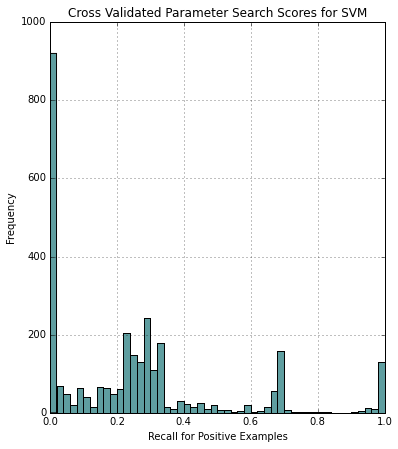

In [29]:
scores = [r.mean_validation_score for r in tuning_resultsSVM.grid_scores_]
plot_histo(scores,
           title="Cross Validated Parameter Search Scores for SVM",
           xlabel="Recall for Positive Examples")



Most sucked, but a few actually did surprisingly well given the simplicity of the models.

So which ones were they?

***************************
GRID SEARCH SCORE: 1.0000
TRAIN SCORE: 1.0000
TEST SCORE: 1.0000
{'count__stop_words': 'english', 'count__max_df': 0.8, 'svm__C': 0.1, 'count__min_df': 1, 'svm__class_weight': 'balanced', 'count__ngram_range': (1, 1), 'count__max_features': 1000, 'svm__kernel': 'poly'}
***************************
GRID SEARCH SCORE: 1.0000
TRAIN SCORE: 1.0000
TEST SCORE: 1.0000
***************************
GRID SEARCH SCORE: 1.0000
TRAIN SCORE: 1.0000
TEST SCORE: 1.0000


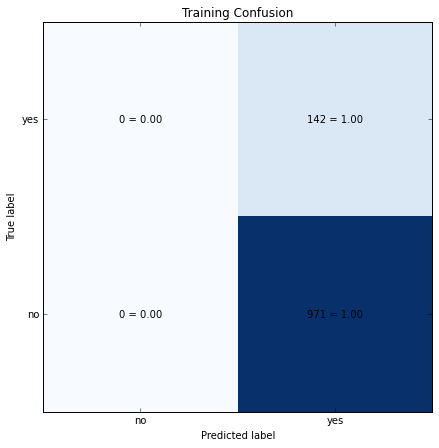

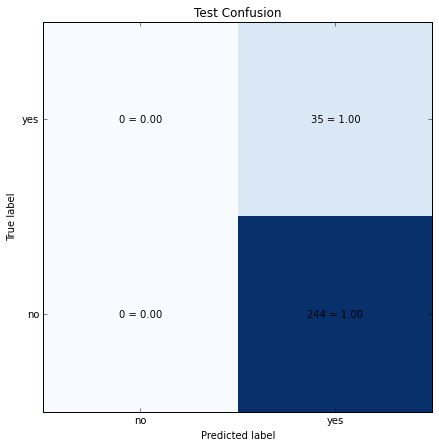

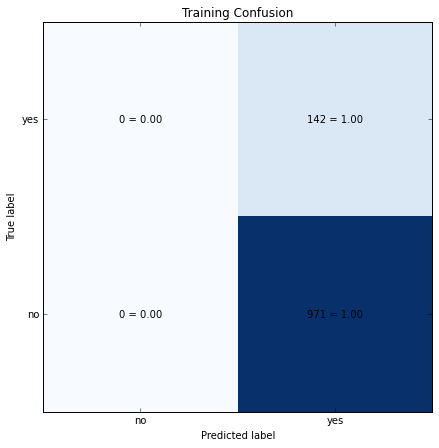

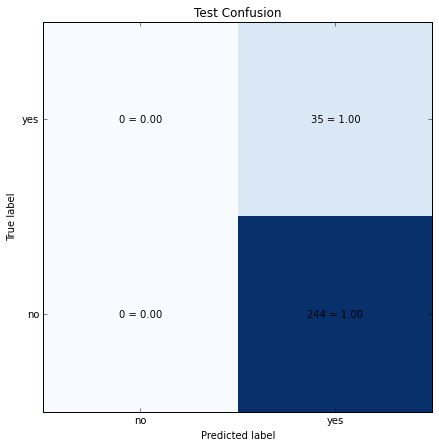

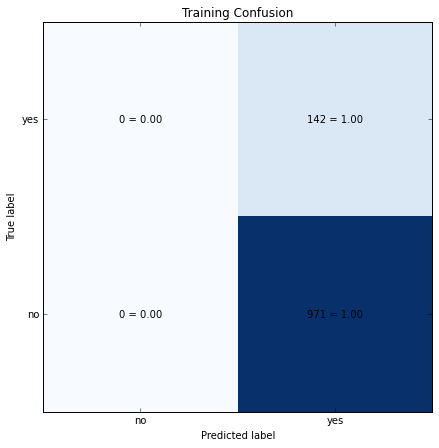

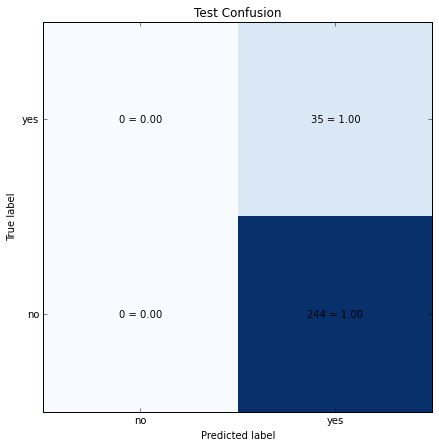

In [30]:
plt.rcParams['figure.figsize'] = (6,7)
topk = 3
ranked_results = sorted(tuning_resultsSVM.grid_scores_, key=lambda x:x.mean_validation_score, reverse=True)
best_score = 0
best_index = 0
best_params = None
for i, result in enumerate(ranked_results[:topk]):
    params = result.parameters
    pip1.set_params(**params).fit(train_data['x'], train_data['y'])
    train_preds = pip1.predict(train_data['x'])
    test_preds = pip1.predict(test_data['x'])
    val = result.mean_validation_score
    print "***************************"
    print "GRID SEARCH SCORE: %0.4f" % val
    tr = pos_recall(train_data['y'], train_preds)
    print "TRAIN SCORE: %0.4f" % tr
    tsr = pos_recall(test_data['y'], test_preds)
    test_score = tsr
    print "TEST SCORE: %0.4f" % test_score
    if test_score > best_score: 
        best_score=test_score
        best_index = i
        best_params = params
        print best_params
    # also let's check out the confusion matrices to see how it looks
    train_cm = metrics.confusion_matrix(train_data['y'], train_preds)
    test_cm = metrics.confusion_matrix(test_data['y'], test_preds)
    plot_confusion_matrix(train_cm, labels, title="Training Confusion")
    plot_confusion_matrix(test_cm, labels, title="Test Confusion") 

### Given the best test score, we can see what those parameters were, and save the model to a file if we want to use it later

In [31]:
from sklearn import svm
best = ranked_results[best_index]
print "BEST TEST POSITIVE RECALL: %0.4f" % best_score
print "BEST MODEL PARAMS: %r" % best_params
model = pip1.set_params(**best_params).fit(data['x'], data['y'])

BEST TEST POSITIVE RECALL: 1.0000
BEST MODEL PARAMS: {'count__stop_words': 'english', 'count__max_df': 0.8, 'svm__C': 0.1, 'count__min_df': 1, 'svm__class_weight': 'balanced', 'count__ngram_range': (1, 1), 'count__max_features': 1000, 'svm__kernel': 'poly'}


In [32]:
from sklearn.externals import joblib
joblib.dump(model, 'multiple_svm_recall.pkl') 

['multiple_svm_recall.pkl',
 'multiple_svm_recall.pkl_01.npy',
 'multiple_svm_recall.pkl_02.npy',
 'multiple_svm_recall.pkl_03.npy',
 'multiple_svm_recall.pkl_04.npy',
 'multiple_svm_recall.pkl_05.npy',
 'multiple_svm_recall.pkl_06.npy',
 'multiple_svm_recall.pkl_07.npy',
 'multiple_svm_recall.pkl_08.npy',
 'multiple_svm_recall.pkl_09.npy',
 'multiple_svm_recall.pkl_10.npy',
 'multiple_svm_recall.pkl_11.npy',
 'multiple_svm_recall.pkl_12.npy',
 'multiple_svm_recall.pkl_13.npy',
 'multiple_svm_recall.pkl_14.npy',
 'multiple_svm_recall.pkl_15.npy',
 'multiple_svm_recall.pkl_16.npy',
 'multiple_svm_recall.pkl_17.npy']

Don't worry about why that has multiple files, just know to load the model later all of those files must be in the directory.

But just refer to it with the original filename

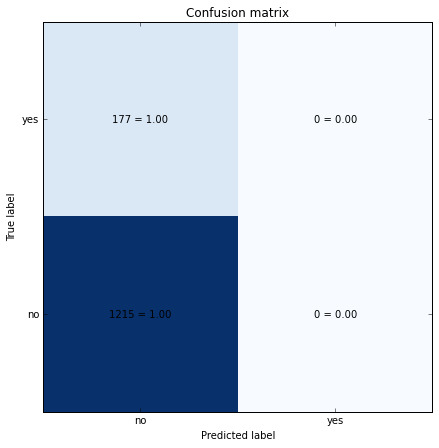

In [33]:
multiple = joblib.load('multiple_svm_recall.pkl') 
preds = multiple.predict(data['x'])

plot_confusion_matrix(metrics.confusion_matrix(data['y'], preds), labels)

## This should give you a good setup to continue improving the models!

Almost all of the info you need for using sci-kitlearn is in the online documentation (as well as a ton of practical tips and examples for how to do good ML in general).

When it comes to plotting stuff, generally I just google "matplotlib _what kind of plot I want_" and someone has usually sdone like 95% of the work already :)

Feel free to send me any questions you have and enjoy your new life in the [wonderful world of python](https://xkcd.com/353/)